In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.inspection import permutation_importance
import seaborn as sns
import xgboost as xgb
import rfpimp
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import shap

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

# pour afficher les graphiques de shap dans le notebook
shap.initjs()

/home/aleon/miniconda3/envs/interpretation_ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Exploration des features importance

## Données du Kaggle ["Two Sigma Connect: Rental Listing Inquiries"](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries) 

But : prédire la popularité ("interest_level") d'un appartement selon ses caractéristiques (certaines informations disponibles dans le jeu de données Kaggle n'ont pas été utilisées ici). 

Les appartements sont situés à New York.

In [2]:
features = ['bathrooms','bedrooms','price','longitude','latitude']
df = pd.read_json("data/train.json")
X = df[features]
y = df['interest_level']
y = y.replace('low',1)
y = y.replace('medium',2)
y = y.replace('high',3)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
X.head()

,bathrooms,bedrooms,price,longitude,latitude
4,1.0,1,2400,-73.9539,40.7108
6,1.0,2,3800,-73.9722,40.7513
9,1.0,2,3495,-73.9625,40.7575
10,1.5,3,3000,-73.9425,40.7145
15,1.0,0,2795,-73.9743,40.7439


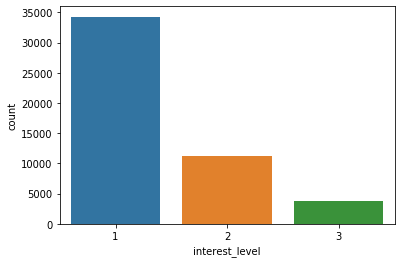

In [3]:
sns.countplot(y)

Il s'agit d'un problème avec des classes déséquilibrées (classe 1 majoritaire)

In [4]:
def get_score_for_each_class(model, X, y):
    """
    fonction pour obtenir un sccore pour chaque classe
    """
    for c in [1,2,3]:
        idx = y[y==c].index
        y_pred = model.predict(X.loc[idx])
        print (f'accuracy for y={c} : {accuracy_score(y_pred, y.loc[idx])}')

## Feature importances de la librairie xgboost
On va d'abord comparer les différentes feature importances disponibles directement dans la librairie xgboost

In [5]:
hyperparam_xgb = {'silent': 1, 'subsample': 0.7, 
                  'n_estimators': 100, 'max_depth': 6, 'objective':'multi:softmax','num_class':3}
xgb_model = xgb.XGBClassifier(**hyperparam_xgb)
xgb_model.fit(X_train, y_train)
pred_train = pd.Series(xgb_model.predict(X_train))
print(f"score sur l'ensemble de train {accuracy_score(pred_train, y_train)}")
pred_val = pd.Series(xgb_model.predict(X_val))
print(f"score sur l'ensemble de test {accuracy_score(pred_val, y_val)}")

score sur l'ensemble de train 0.7719945561772267
score sur l'ensemble de test 0.7132068520906244


In [6]:
print ("accuracy pour l'ensemble de train pour chaque classe : ")
get_score_for_each_class(xgb_model, X_train, y_train)
print ("accuracy pour l'ensemble de test pour chaque classe : ")
get_score_for_each_class(xgb_model, X_val, y_val)

accuracy pour l'ensemble de train pour chaque classe : 
accuracy for y=1 : 0.9634454513767864
accuracy for y=2 : 0.324453915823122
accuracy for y=3 : 0.3750479846449136
accuracy pour l'ensemble de test pour chaque classe : 
accuracy for y=1 : 0.9331980232968584
accuracy for y=2 : 0.20585864015049718
accuracy for y=3 : 0.22285251215559157


Très rapidement : les performances sont surtout bonnes pour la classe 1 majoritaire et donc beaucoup plus facile à prédire. Il faudrait utiliser des méthodes (et des métriques) adaptées pour des problèmes avec classes ddéséquilibrées, pour avoir de meilleurs résultats.

### feature importance : weight (what is used in model.feature_importances_)
= The number of times a feature is used to split the data accross all trees

Text(0.5, 1.0, 'feature importance : weight')

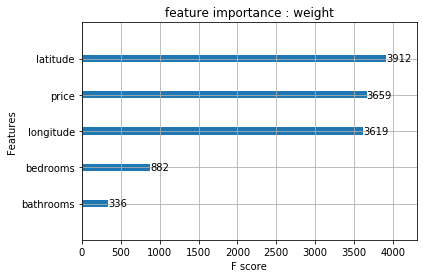

In [7]:
xgb.plot_importance(xgb_model)
plt.title("feature importance : weight")

### feature importance : cover
= The average coverage across all splits the feature is used in, i.e. the number of time a feature is used to split the data accross all trees weighted by the number of training data points that go through those splits.

Text(0.5, 1.0, 'feature importance : cover')

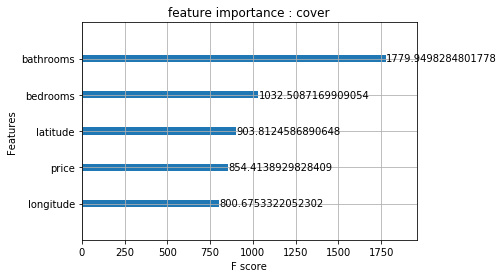

In [8]:
xgb.plot_importance(xgb_model, importance_type="cover")
plt.title("feature importance : cover")

### feature importance : gain
= The average gain accross all splits the feature is used in, i.e. the average training loss reduction gained when using a feature for splitting.

Text(0.5, 1.0, 'feature importance : gain')

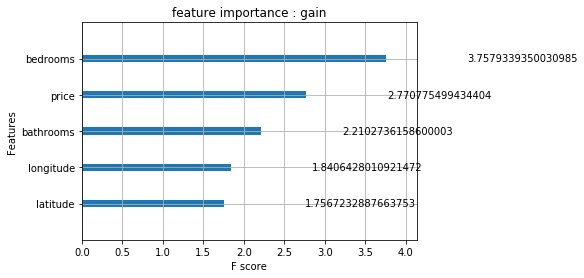

In [9]:
xgb.plot_importance(xgb_model, importance_type="gain")
plt.title("feature importance : gain")

### Conclusion :
Les résultats entre les feature importances sont tous différents ! On ne sait donc pas auquel se fier.

## Feature importances from RandomForest sklearn

In [10]:
rf_model = RandomForestClassifier(
         n_estimators=100,
         min_samples_leaf=1,
         n_jobs=-1,
         oob_score=True)
rf_model.fit(X_train, y_train)
pred_train = pd.Series(rf_model.predict(X_train))
print(f"score sur l'ensemble de train {accuracy_score(pred_train, y_train)}")
pred_val = pd.Series(rf_model.predict(X_val))
print(f"score sur l'ensemble de test {accuracy_score(pred_val, y_val)}")

score sur l'ensemble de train 0.9247542718887041
score sur l'ensemble de test 0.6963222201756002


In [11]:
print ("accuracy pour l'ensemble de train pour chaque classe : ")
get_score_for_each_class(rf_model, X_train, y_train)
print ("accuracy pour l'ensemble de test pour chaque classe : ")
get_score_for_each_class(rf_model, X_val, y_val)

accuracy pour l'ensemble de train pour chaque classe : 
accuracy for y=1 : 0.9713750435691879
accuracy for y=2 : 0.82059136920618
accuracy for y=3 : 0.8142034548944338
accuracy pour l'ensemble de test pour chaque classe : 
accuracy for y=1 : 0.8668372749735263
accuracy for y=2 : 0.3104004299919377
accuracy for y=3 : 0.2941653160453809


Avec ces hyper-paramètres, on a plus de sur-apprentissage avec RandomForest qu'avec Xgboost, mais les résultats sont meilleurs pour les classes 2 et 3 avec peu de représentants.

### Feature importances : Mean Decrease in Impurity (MDI)

Also called Gini importance. In sklearn it's the total decrease in node impurity (weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.

__Correspond to "gain importance" for xgboost.__

In [12]:
def plot_mdi_importance(rf_model, features):
    tree_feature_importances = (rf_model.feature_importances_)
    sorted_idx = tree_feature_importances.argsort()
    y_ticks = np.arange(0, len(features))
    fig, ax = plt.subplots()
    ax.barh(y_ticks, tree_feature_importances[sorted_idx])
    ax.set_yticklabels(pd.Series(features)[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title("Random Forest Feature Importances (MDI)")
    fig.tight_layout()
    plt.show()

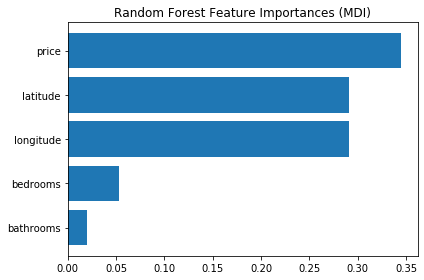

In [13]:
plot_mdi_importance(rf_model, features)

On a encore des importances différentes... à noter cependant qu'on ne peut pas les comparer directement avec celles du modèle xgboost : les modèles utilisés sont différents, et comme __les feature importances dépendent du modèle__, c'est parfaitement possible que des modèles différents utilisent des variables différentes !

### Permutation importance
Pour un jeu de donnée, pour une variable i, on regarde la différence de performance entre :
- les données telles quelles
- les données où on permute entre elles les valeurs

Cette importance est disponible dans sklearn depuis la version 0.22

In [14]:
X.head()

,bathrooms,bedrooms,price,longitude,latitude
4,1.0,1,2400,-73.9539,40.7108
6,1.0,2,3800,-73.9722,40.7513
9,1.0,2,3495,-73.9625,40.7575
10,1.5,3,3000,-73.9425,40.7145
15,1.0,0,2795,-73.9743,40.7439


In [15]:
def plot_permutation_importance(rf_model, X, y):
    result = permutation_importance(rf_model, X, y, n_repeats=5,
                                    random_state=42, n_jobs=1)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X.columns[sorted_idx])
    ax.set_title("Permutation Importances")
    fig.tight_layout()
    plt.show()

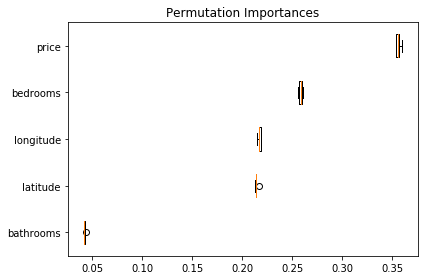

In [16]:
plot_permutation_importance(rf_model, X_train, y_train)

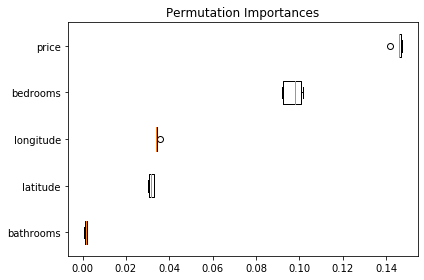

In [17]:
plot_permutation_importance(rf_model, X_val, y_val)

### Remarques importantes :
On remarque des valeurs différentes entre les ensembles de train et test. En particulier, pour l'ensemble de test, les valeurs d'importance sont très faibles : pour des valeurs inférieures à 0.10, la variable a peu d'influence sur la mesure de performance utilisée.

Ici, on pourrait considérer que longitude+latitude entraine du sur-apprentissage et qu'il faut les retirer, mais on a alors de moins bons résultats :

In [18]:
X_train2 = X_train[['bathrooms','bedrooms','price']]
X_val2 = X_val[['bathrooms','bedrooms','price']]
rf_model2 =clone(rf_model)
rf_model2.fit(X_train2, y_train)
pred_train = pd.Series(rf_model2.predict(X_train2))
print(f"train : {+accuracy_score(pred_train, y_train)}")
get_score_for_each_class(rf_model2, X_train2, y_train)
print(f"test :{accuracy_score(pred_val, y_val)}")
get_score_for_each_class(rf_model2, X_val2, y_val)

train : 0.7362770300922425
accuracy for y=1 : 0.9641861275705821
accuracy for y=2 : 0.2153702717101758
accuracy for y=3 : 0.22955854126679462
test :0.6963222201756002
accuracy for y=1 : 0.9324920578891635
accuracy for y=2 : 0.12416017199677506
accuracy for y=3 : 0.14019448946515398


Effectivement en les retirant on diminue le sur-apprentissage... mais on dégrade également les performances, en particulier pour les classes 2 et 3. 
- mais la permutation importance regarde les performances globales : on pourrait vouloir évaluer les performances avec une métrique particulière, par exemple en donnant plus de poids aux petites classes (c'est possible !)
- et les variables latitues et longitudes devraient sans doute être permutées ensembles : n'importe quelle longitude n'a pas forcément du sens avec n'importe quelle latitude

## Random feature
On peut tester d'ajouter une variable aléatoire pour voir son importance dans les prédictions. Idéalement, son importance devrait être faible...

In [19]:
X_train3 = X_train.copy()
X_train3['random'] = np.random.random(size=len(X_train3))
X_val3 = X_val.copy()
X_val3['random'] = np.random.random(size=len(X_val3))
rf_model3 = RandomForestClassifier(
         n_estimators=100,
         min_samples_leaf=1,
         n_jobs=-1,
         oob_score=True)
rf_model3.fit(X_train3, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

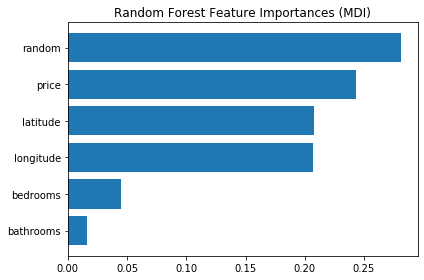

In [20]:
plot_mdi_importance(rf_model3, features+['random'])

La variable aléatoire parait cependant importante ! C'est parce que :
- c'est une variable continue, qui apparait plus facilement dans les splits des arbres et qui peut donc sembler avoir plus d'importance selon les feature imp. qui dépendent du nombre de splits comme ici
- l'importance MDI dépend des données d'entraînement et non de test

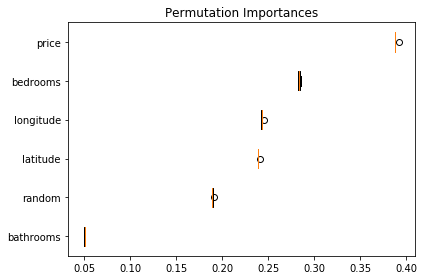

In [21]:
plot_permutation_importance(rf_model3, X_train3, y_train)

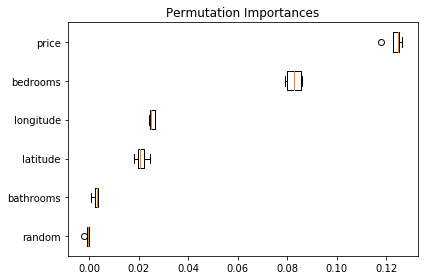

In [22]:
plot_permutation_importance(rf_model3, X_val3, y_val)

Pour la permutation importances, sur les données de train la variable parait quand même avoir une influence, mais pas sur les donnéees de test : elle est sans doute essentiellement utilisée pour du sur-apprentissage.

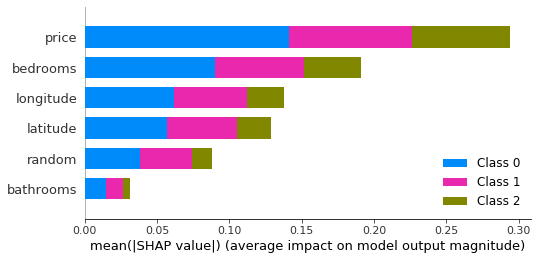

In [23]:
explainer = shap.TreeExplainer(rf_model3)
X_train3_sample = X_train3.sample(1000)
shap_values_train3 = explainer.shap_values(X_train3_sample.values)
shap.summary_plot(shap_values_train3, X_train3_sample, plot_type="bar")

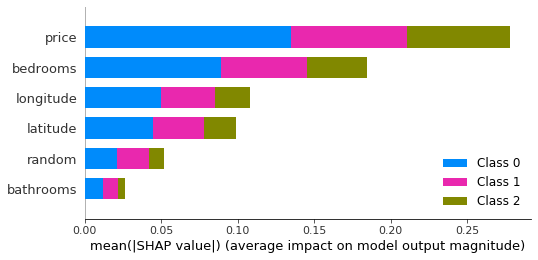

In [24]:
explainer = shap.TreeExplainer(rf_model3)
X_val3_sample = X_val3.sample(1000)
shap_values_val3 = explainer.shap_values(X_val3_sample.values)
shap.summary_plot(shap_values_val3, X_val3_sample, plot_type="bar")

# Corrélations entre variables

### Duplication d'une variable
On teste les effets de la corrélation entre variables en duplicant une variable.

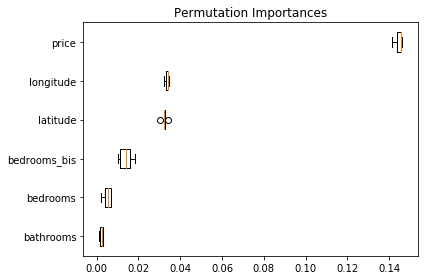

In [25]:
rf_model_bis = RandomForestClassifier(
         n_estimators=100,
         min_samples_leaf=1,
         n_jobs=-1,
         oob_score=True)
X_train_bis = X_train.copy()
X_val_bis = X_val.copy()
X_train_bis['bedrooms_bis'] = X_train_bis['bedrooms']
X_val_bis['bedrooms_bis'] = X_val_bis['bedrooms']
rf_model_bis.fit(X_train_bis, y_train)
plot_permutation_importance(rf_model_bis, X_val_bis, y_val)

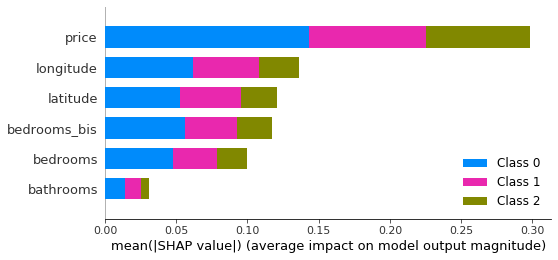

In [26]:
explainer = shap.TreeExplainer(rf_model_bis)
X_val_sample = X_val_bis.sample(1000)
shap_values_val = explainer.shap_values(X_val_sample.values)
shap.summary_plot(shap_values_val, X_val_sample, plot_type="bar")

En duplicant "bedrooms", on peut avoir l'impression que la variable est moins importante, car les importances sont partagées entre bedrooms et bedrooms_bis.

### Permutation de plusieurs colonnes (on permute plusieurs colonnes pour évaluer l'effet groupé mais on ne permute pas les variables d'une même donnée "ensembles")
La librairie rfpimp https://github.com/parrt/random-forest-importances est spécialisée dans l'utilisation de la permutation importances. Une plus longue discussion sur les feature importances (qui a inspiré ce notebook) est disponible sur https://explained.ai/rf-importance/index.html

Elle permet en particulier de permuter plusieurs variables en même temps.

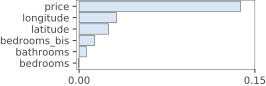

In [27]:
I = rfpimp.importances(rf_model_bis, X_val_bis, y_val)
rfpimp.plot_importances(I)

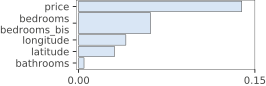

In [28]:
I = rfpimp.importances(rf_model_bis, X_val_bis, y_val, features=['price','latitude','longitude','bathrooms',['bedrooms','bedrooms_bis']])
rfpimp.plot_importances(I)

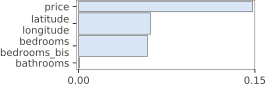

In [29]:
I = rfpimp.importances(rf_model_bis, X_val_bis, y_val, features=['price',['latitude','longitude'],'bathrooms',['bedrooms','bedrooms_bis']])
rfpimp.plot_importances(I)

__Quand l'importance d'une variable est faible, cela signifie :__
- soit que la variable n'est pas importante
- soit que la variable est très corrélée à une ou plusieurs autres variables

### Duplication avec bruit d'une variable

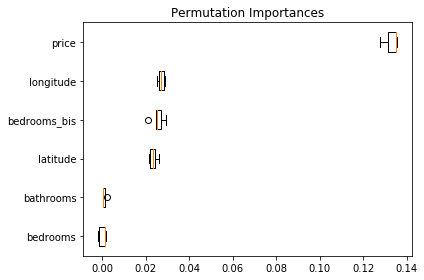

In [30]:
rf_model_bis = RandomForestClassifier(
         n_estimators=100,
         min_samples_leaf=1,
         n_jobs=-1,
         oob_score=True)
X_train_bis = X_train.copy()
X_val_bis = X_val.copy()
X_train_bis['bedrooms_bis'] = X_train_bis['bedrooms']+np.random.random(len(X_train_bis)) * 1
X_val_bis['bedrooms_bis'] = X_val_bis['bedrooms']+np.random.random(len(X_val_bis)) * 1
rf_model_bis.fit(X_train_bis, y_train)
plot_permutation_importance(rf_model_bis, X_val_bis, y_val)

### Corrélations entre les variables

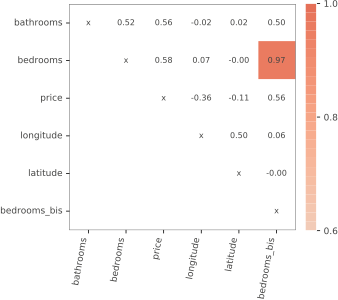

In [31]:
rfpimp.plot_corr_heatmap(X_train_bis, figsize=(5,5), value_fontsize=8)

### Utilisation d'une autre métrique

In [32]:
def plot_permutation_importance2(rf_model, X, y):
    result = permutation_importance(rf_model, X, y, n_repeats=10,
                                    random_state=42, n_jobs=1, 
                                   scoring='balanced_accuracy')
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X.columns[sorted_idx])
    ax.set_title("Permutation Importances")
    fig.tight_layout()
    plt.show()

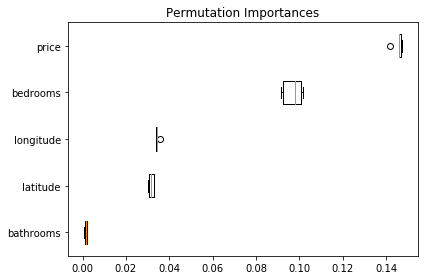

In [33]:
# metrique "accuracy"
plot_permutation_importance(rf_model, X_val, y_val)

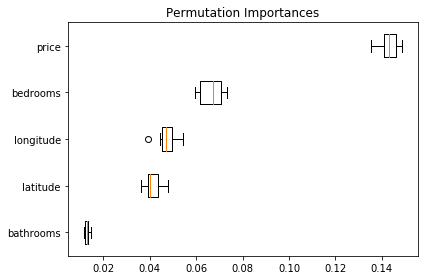

In [34]:
# métrique "balanced_accuracy"
plot_permutation_importance2(rf_model, X_val, y_val)